#1.Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Grammatical_Error_correction/

/content/drive/MyDrive/Grammatical_Error_correction


#2.Installation and Import

In [ ]:
!pip install wordcloud

In [ ]:
import random
import numpy as np
import pandas as pd
import regex as re
from tqdm import tqdm
from scipy.stats import mode
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

#3.Read Data

In [ ]:
data = pd.read_csv('./Data/csv_data/lang8/lang8_anno_id0.csv')

#4.Exploratory Data Analysis

##4.1.dataframe info() and describe()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037562 entries, 0 to 1037561
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   correct      1037560 non-null  object
 1   incorrect    1037560 non-null  object
 2   total_edits  1037562 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 23.7+ MB


**Observation:** <br>
There are 2 null values


In [ ]:
data.describe()

,total_edits
count,1.037562e+06
mean,1.141918e+00
std,1.709852e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,2.000000e+00
max,1.670000e+02


##4.2.Remove na values

In [ ]:
data[data.isna().any(axis=1)]

,correct,incorrect,total_edits
222211,NaN,NaN,0
1037561,NaN,NaN,0


In [ ]:
data.dropna(axis=0, how='any', inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(1037560, 3)

##4.3.Check for duplicate and remove

In [ ]:
data.duplicated(['correct','incorrect']).values.sum()

86813

In [ ]:
data[data.duplicated(['correct','incorrect'])].sample(50)

,correct,incorrect,total_edits
651629,I am 19 years old .,I am 19 years old .,0
603342,Nice to meet you !,Nice to meet you !,0
522819,Long time no write,Long time no write,0
51136,p . s .,p . s .,0
723349,Long time no see,Long time no see,0
196009,S .,S .,0
709383,bye .,bye .,0
780012,7 .,7 .,0
40136,Hello everyone !,Hello everyone !,0
153391,: ),: ),0


Observation: <br>
There are 86813 duplicated rows.  <br> 
We can see there are duplicates like "URL", "Hi", "Hello" and etc

In [ ]:
data.drop_duplicates(['correct','incorrect'], inplace=True, keep='first')
data.reset_index(drop=True, inplace=True)
data.shape

(950747, 3)

##4.4.Visualization of sample points

In [ ]:
data.head()

,correct,incorrect,total_edits
0,Good luck on your new start !,Good luck on your new start !,0
1,My teacher is going to move to change his job .,My teacher is going to move to change his job .,0
2,He is a so nice guy and taught me English very...,He is a so nice guy and taught me English very...,0
3,And he took in my favorite subjects like soccer .,And he took in my favorite subject like soccer .,1
4,"Actually , he was the one who let me know abou...","Actually , who let me know about Lang - 8 was ...",2


In [ ]:
data.tail()

,correct,incorrect,total_edits
950742,"As the date had been promised at noon , I went...","As the date had been promised at noon , I went...",0
950743,11 a . m . and toward the meeting place by sub...,11 a . m . and toward the meeting place by sub...,0
950744,"On the way , I got a mail from her .","On the way , I got a mail from her .",0
950745,she said she want to change the meeting time t...,"It said , she want to make the meeting time at...",4
950746,"So , I had to be wandering around for about 4 ...","So , I had to be wandering around for about 4 ...",0


In [ ]:
data.sample(10)

,correct,incorrect,total_edits
506199,I go there too frequently ?,Do I go there too frequently ?,1
916001,Maybe it 's time to write my article to gradua...,Maybe it 's time to write my article to gradua...,0
911695,"I like it , and I do n't get to hear about it ...","I like it , I cant to listen it everyday .",4
385082,Today I 'm going to give a presentation about ...,Today I 'm going to give a presentation about ...,1
122712,Every word can give good explanations through ...,Every word can be given good explanations by a...,2
465882,But we must look on the bright side .,But look on the bright side .,1
444154,eh that 's all that I want to write to you .,"eh ~ ~ I write to you today , that 's all .",5
203420,I always listen to music everynight on FM radi...,I always listen to music everynight on FM radi...,0
63784,"A few days ago , this department store announc...","A few days ago , this department store announc...",0
80772,I have lived in Kamakura since June 2010 .,I have lived in Kamakura since 2010 June .,1


Observation: <br>
We can see that there are numbers and special characters, those has to be removed as they do not add much to model learning

##4.5.Preprocessing text data

In [ ]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
def clean(text):
    """
    takes string as input and
    removes characters inside (),{},[] and <>
    removes characters like -+@#^/|*(){}$~`
    we not not removing ,.!-:;"' as these characters are present in english language 
    """
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~<>=_%:;]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    text = text.lower()
    text = text.strip()
    return text

In [ ]:
data['incorrect'] = data['incorrect'].apply(decontracted)
data['correct'] = data['correct'].apply(decontracted)

In [ ]:
data['incorrect'] = data['incorrect'].apply(clean)
data['correct'] = data['correct'].apply(clean)

after processing lets check for any nan/null values


In [ ]:
data.isna().any()

correct        False
incorrect      False
total_edits    False
dtype: bool

We observed there are no nan values. lets check if there are any empty values. Becaues there are few string like: <br> 

incorrect: 'See you later !  )'
corrected: '(See you later)'

after preprocessing they are changed to:
incorrect: 'See you later ! : )'
correct: ''    

Visualizatio of sample points after cleaning

In [ ]:
data[(data['incorrect'] == '') | (data['correct'] == '')].shape

(4401, 3)

**Observation:** <br>
1. We have 4401 rows with either "incorrect" or "correct" column as ''. 
2. Lets remove those

In [ ]:
data.drop(index=data[(data['incorrect'] == '') | (data['correct'] == '')].index, inplace=True)

In [ ]:
data.shape

(946346, 3)

In [ ]:
data.sample(20)

,correct,incorrect,total_edits
28546,he also said many people had already enquired ...,he also said many people had already enquired ...,0
685262,i know it is not good for myself nor my surrou...,i know it is not good for myself and my surrou...,1
878707,that is why today is title is written in fre...,that is why today is title is written in fre...,0
808832,i had tied it on my shorts in order to prevent...,i had tied it on my shorts in order to prevent...,0
643115,"some peach blossoms , rice cakes , and sweets ...","some peach blossoms , rice cakes , some sweeet...",4
309360,"today , i played tennis .","today , i played tennis .",0
574842,do you know sweet potato ?,do you know sweet potate ?,1
259168,domestic disaster,domestic disaster,0
736614,"i have totally no idea what to do now , but i ...","i have totaly no idea what to do now but , i ...",5
604640,"they will rot , if they are not on ice .","they will rot , if they wo not on ice .",2


In [ ]:
data.sample(10)

,correct,incorrect,total_edits
664823,tomorrow i am going to meet the copier machin...,tomorrow i am going to meet copy machine sals...,2
249753,life is hard,life is hard,0
518561,it is a traditional alcohol of korea .,it is tradition alcohol of korea,5
204679,i got some e mails from my old student today .,i got some e mails from old student today .,1
547586,"it was very exciting , impressive and wonderfu...","it was very exciting , impressive and wonderfu...",0
73816,"from now on , i just want to try to understand...","from now on , i just wanna try to solve some p...",2
435176,my name is mica .,my name is mica .,0
792458,because i can write sentence after thought .,because i can write sentence after i thought .,1
311593,i arrange my bag and put inside it my notebook...,"i arrange my bag , i put inside it my notebook...",3
340323,you have been waiting for a long time .,you have been waiting for a long time .,0


After cleaning, lets check for duplicates after removing special characters

In [ ]:
data.duplicated(['correct','incorrect']).values.sum()

16613

**Obsevation :** <br>
1. We can see after preprocessing there are 16613 duplicate values
2. removing those as they do not add for model training

In [ ]:
data[data.duplicated(['correct','incorrect'])]

,correct,incorrect,total_edits
225,bye !,bye !,0
342,self introduction,self introduction,0
371,.,.,0
374,.,.,0
377,.,.,0
...,...,...,...
950368,hello everyone ! ! !,hello everyone ! ! !,0
950410,aeroflot,aeroflot,0
950539,.,.,0
950641,life insurance,life insurance,0


In [ ]:
data.drop_duplicates(['correct','incorrect'], inplace=True, keep='first')
data.reset_index(drop=True, inplace=True)
data.shape

(929733, 3)

In [ ]:
data.isna().any()

correct        False
incorrect      False
total_edits    False
dtype: bool

In [ ]:
data.to_csv('./Data/csv_data/lang8/lang8_anno_id0_preprocessed.csv', index=False)

In [ ]:
data = pd.read_csv('./Data/csv_data/lang8/lang8_anno_id0_preprocessed.csv')

##4.6.Univariate Analysis

###4.6.1.Analysis on characters

####4.6.1.1.Incorrect 

In [ ]:
char_count = lambda x: len(str(x))

In [ ]:
data['incorrect_char_len'] = data['incorrect'].apply(char_count)
data['correct_char_len'] = data['correct'].apply(char_count)

In [ ]:
data.sample(10)

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len
391277,another busy day !,another busy day !,0,18,18
741102,the aim of my visit was to eat the bison burger .,the aim of my visit was to eat the bison burger .,0,49,49
822288,today was the last day of school in this year ...,today was the last day of school in this year ...,0,112,112
188763,describe your dream workplace .,describe your dream workplace .,0,31,31
350892,my name is krokawa .,my name is krokawa .,0,20,20
375947,my throat was still sore .,my throat was still soar .,1,26,26
572074,because i think he deserves the yankees .,"because he deserves the yankees , i think .",3,43,42
845520,"today , i searched for my german friend is na...","today , i searched my germany friend in her na...",3,50,50
921460,and through some windows i can see some green ...,and through some windows i can see some greeen...,1,64,63
439395,"i am not flabby , but it is important to avo...","i am not flabby , but it is important to avo...",0,85,85


####character range in incorrect data points

In [ ]:
data['incorrect_char_len'].min(), data['incorrect_char_len'].max()

(1, 1769)

Observation: <br> 
1. we have min character length as 1, may be a single character. We should remove these points as they do not add much for model training

In [ ]:
data[data['incorrect_char_len'] == 1]

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len
364,.,.,0,1,1
460,d,d,0,1,1
1412,w,w,0,1,1
2064,t,t,0,1,1
2703,a,a,0,1,1
4704,x,x,0,1,1
7755,!,!,0,1,1
7883,p,p,0,1,1
8298,',',0,1,1
9045,?,?,1,1,1


In [ ]:
data = data[data['incorrect_char_len'] > 1]
data.reset_index(drop=True, inplace=True)
data.shape

(929673, 5)

####Percentile values

In [ ]:
for p in range(0,101,10):
  p_value = np.percentile(data['incorrect_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')

0 th percentile value is: 2.0
10 th percentile value is: 20.0
20 th percentile value is: 28.0
30 th percentile value is: 34.0
40 th percentile value is: 41.0
50 th percentile value is: 47.0
60 th percentile value is: 55.0
70 th percentile value is: 65.0
80 th percentile value is: 77.0
90 th percentile value is: 99.0
100 th percentile value is: 1769.0


In [ ]:
for p in range(90,101):
  p_value = np.percentile(data['incorrect_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')

90 th percentile value is: 99.0
91 th percentile value is: 103.0
92 th percentile value is: 106.0
93 th percentile value is: 111.0
94 th percentile value is: 116.0
95 th percentile value is: 122.0
96 th percentile value is: 129.0
97 th percentile value is: 139.0
98 th percentile value is: 153.0
99 th percentile value is: 178.0
100 th percentile value is: 1769.0


####4.6.1.2.correct

####character range in correct data points

In [ ]:
data['correct_char_len'].min(), data['correct_char_len'].max()

(1, 2623)

In [ ]:
data[data['correct_char_len'] == 1]

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len
19256,.,daily life .,1,12,1
20652,.,took some medicine .,1,20,1
55788,.,"i think , it is not true in real life i think .",4,48,1
59247,.,you .,1,5,1
68569,",","maiko nakai ,",1,13,1
68570,.,hello .,1,7,1
82173,.,things had been changing gradually and irrever...,3,68,1
83768,.,at first .,1,10,1
141562,d,im fresh man d,1,15,1
155261,.,to near park .,1,14,1


In [ ]:
data = data[data['correct_char_len'] > 1]
data.reset_index(drop=True, inplace=True)
data.shape

(929615, 5)

####Percentile

In [ ]:
for p in range(0,101,10):
  p_value = np.percentile(data['correct_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')

0 th percentile value is: 2.0
10 th percentile value is: 21.0
20 th percentile value is: 28.0
30 th percentile value is: 35.0
40 th percentile value is: 42.0
50 th percentile value is: 48.0
60 th percentile value is: 56.0
70 th percentile value is: 66.0
80 th percentile value is: 78.0
90 th percentile value is: 101.0
100 th percentile value is: 2623.0


In [ ]:
for p in range(90,101):
  p_value = np.percentile(data['correct_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')

90 th percentile value is: 101.0
91 th percentile value is: 104.0
92 th percentile value is: 108.0
93 th percentile value is: 112.0
94 th percentile value is: 117.0
95 th percentile value is: 123.0
96 th percentile value is: 131.0
97 th percentile value is: 140.0
98 th percentile value is: 155.0
99 th percentile value is: 179.0
100 th percentile value is: 2623.0


###4.6.2.Analysis on words

In [ ]:
word_count = lambda x: len(str(x).split()) 

In [ ]:
data['incorrect_word_len'] = data.iloc[:, 1].apply(word_count)
data['correct_word_len'] = data.iloc[:, 0].apply(word_count)

In [ ]:
data.head()

,correct,incorrect,total_edits,incorrect_char_len,correct_char_len,incorrect_word_len,correct_word_len
0,good luck on your new start !,good luck on your new start !,0,29,29,7,7
1,my teacher is going to move to change his job .,my teacher is going to move to change his job .,0,47,47,11,11
2,he is a so nice guy and taught me english very...,he is a so nice guy and taught me english very...,0,106,106,23,23
3,and he took in my favorite subjects like soccer .,and he took in my favorite subject like soccer .,1,48,49,10,10
4,"actually , he was the one who let me know abou...","actually , who let me know about lang was him .",2,49,58,11,14


In [ ]:
data.to_csv('./Data/csv_data/lang8/lang8_anno_id0_preprocessed_word.csv', index=False)

In [ ]:
data = pd.read_csv('./Data/csv_data/lang8/lang8_anno_id0_preprocessed_word.csv')

####4.6.2.1.Incorrect: How words in Incorrect sentences are distributed

#####Histogram

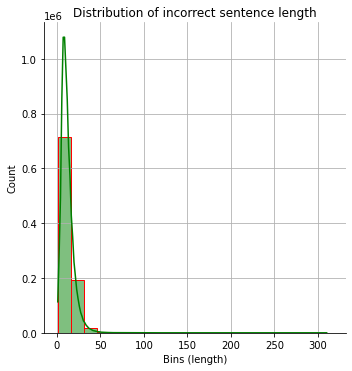

In [ ]:
hist_bins = list(range(data['incorrect_word_len'].min(), data['incorrect_word_len'].max()+15,15))
sns.displot(list(data['incorrect_word_len'].values), bins=hist_bins, kde=True, color='green',edgecolor='red')
plt.grid()
plt.title('Distribution of incorrect sentence length')
plt.xlabel("Bins (length)")
plt.show()

**Observation:** <br>
1. Most of data points has length between 1-15
2. Most of datapoints has length less than or equal to 50
3. Data is not normally distributed

#####Cumulative distribution

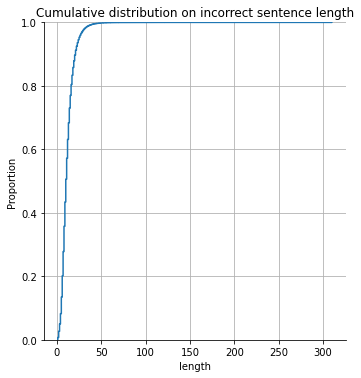

In [ ]:
sns.displot(data['incorrect_word_len'].values, kind='ecdf')
plt.xlabel("length")
plt.title("Cumulative distribution on incorrect sentence length")
plt.grid()
plt.show()

**Observation:** <br>
1. We can see 99% of data points has length less than 50

#####Statistics - Mean, Median, Mode

In [ ]:
print("Length statistics of incorrect sentences:")
print("="*100)

print("Minimum : ", data['incorrect_word_len'].min())
print("Maximum : ", data['incorrect_word_len'].max())
print("Mean : ", data['incorrect_word_len'].mean())
print("Median : ", data['incorrect_word_len'].median())
print("Mode : ", mode(data['incorrect_word_len'].values))

Length statistics of incorrect sentences:
Minimum :  1
Maximum :  310
Mean :  11.909582999413736
Median :  10.0
Mode :  ModeResult(mode=array([8]), count=array([74105]))


**Observation:** <br>
1. Mean > Median > Mode so data is right skewed
2. Most of the sentences (74225) has length = 8

#####0-100 percentile in steps of 10

In [ ]:
p_value = list(range(0,101,10))

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["incorrect_word_len"].values,p))}')

0th percentile value is 1.0
10th percentile value is 5.0
20th percentile value is 6.0
30th percentile value is 8.0
40th percentile value is 9.0
50th percentile value is 10.0
60th percentile value is 12.0
70th percentile value is 14.0
80th percentile value is 16.0
90th percentile value is 21.0
100th percentile value is 310.0


Observation: <br> 
1. 90% of datapoints has length less than or equal to 21
2. We can see there is large variance between 90-100percentile

#####90-100 percentile in steps of 1

In [ ]:
p_value = list(range(90,101))

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["incorrect_word_len"].values,p))}')

90th percentile value is 21.0
91th percentile value is 21.0
92th percentile value is 22.0
93th percentile value is 23.0
94th percentile value is 24.0
95th percentile value is 25.0
96th percentile value is 27.0
97th percentile value is 28.0
98th percentile value is 31.0
99th percentile value is 36.0
100th percentile value is 310.0


**Observation:** <br>
1. 99% of datapoints has length less than or equal to 36
2. There is large variance between 99-100 percentile

#####99.1-100 percentile in step of .1

In [ ]:
p_value = [99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["incorrect_word_len"].values,p))}')

99.1th percentile value is 37.0
99.2th percentile value is 38.0
99.3th percentile value is 39.0
99.4th percentile value is 40.0
99.5th percentile value is 42.0
99.6th percentile value is 43.0
99.7th percentile value is 46.0
99.8th percentile value is 50.0
99.9th percentile value is 57.0
100th percentile value is 310.0


**Observation:** <br>
1. Only .1% of datapoints has length greater than 57

#####Visualization of points whose length greater than 56 (99.9%)

In [ ]:
data[data['incorrect_word_len'] >= 56]['incorrect'].values.shape

(1069,)

In [ ]:
random.sample(data[data['incorrect_word_len'] >= 56]['incorrect'].values.tolist(), 10)

['when at work is not much to do i pick up my notebook and start practice my hiragana  katakana , i hope some day be as good as that , that i would go to japan to sharp my skills , my all life dream is to become into a internacional bissenes bachelort and to be working all over the world , but now on it seems so much like a dream , that i much of the times feld down and surpassed for such a dream i have so , getting back to the main point , after finished my work at my fathers place y took my computer and watched some anime material i did have in .',
 'and i had to come to office this morning before    , so i had to get up before  , so terrible , but it  is strange that i did  not feel sleepy today , just i did feel that i was not in myself . . . emm . . . like , i was just sitting here , doing nothing , thinking nothing . . .',
 'the main characters of the serie are keroro , that is very childish and selfish and always try to make laugh people , but he is a very bad comedian , then we

**Observation:** <br>
1. We can see there are 1069 datapoints whose length is greater than or equal  99.9%
2. All these points seems to be genuine points, not an outlier/random points


####4.6.2.2.Correct: How words in correct sentences are distributed

#####Histogram

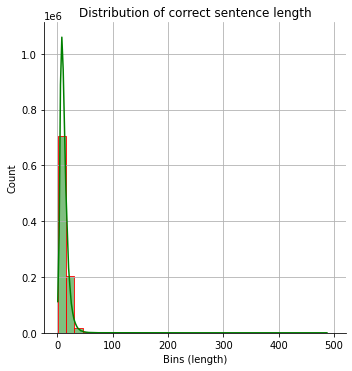

In [ ]:
hist_bins = list(range(data['correct_word_len'].min(), data['correct_word_len'].max()+15,15))
sns.displot(list(data['correct_word_len'].values), bins=hist_bins, kde=True, color='green',edgecolor='red')
plt.grid()
plt.title('Distribution of correct sentence length')
plt.xlabel("Bins (length)")
plt.show()

**Observation:** <br>
1. We can see most of the sentences length lie between 0-15
2. We can see most of the sentences has length less than 50
3. Data is not normally distributed

#####Cumulative distribution

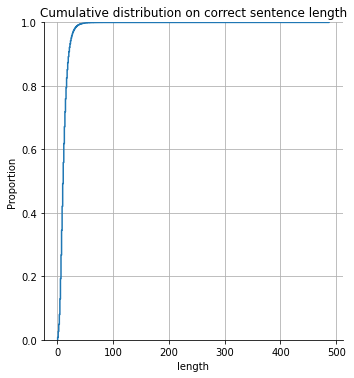

In [ ]:
sns.displot(data['correct_word_len'].values, kind='ecdf')
plt.xlabel("length")
plt.title("Cumulative distribution on correct sentence length")
plt.grid()
plt.show()

Observation: <br>
1. 90% of datapoints length less than or equal 50

#####Statistics - Mean, Median, Mode

In [ ]:
print("Length statistics of correct sentences:")
print("="*100)

print("Minimum : ", data['correct_word_len'].min())
print("Maximum : ", data['correct_word_len'].max())
print("Mean : ", data['correct_word_len'].mean())
print("Median : ", data['correct_word_len'].median())
print("Mode : ", mode(data['correct_word_len'].values))

Length statistics of correct sentences:
Minimum :  1
Maximum :  487
Mean :  12.10741973827875
Median :  11.0
Mode :  ModeResult(mode=array([8]), count=array([72182]))


**Observation:** <br>
1. Mean > Median > Mode so data is right skewed
2. Most of the sentences (72312) has length = 8

#####0-100 percentile in steps of 10

In [ ]:
p_value = list(range(0,101,10))

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["correct_word_len"].values,p))}')

0th percentile value is 1.0
10th percentile value is 5.0
20th percentile value is 7.0
30th percentile value is 8.0
40th percentile value is 9.0
50th percentile value is 11.0
60th percentile value is 12.0
70th percentile value is 14.0
80th percentile value is 17.0
90th percentile value is 21.0
100th percentile value is 487.0


Observation: <br>
1. 90% of data points has length less than or equal to 21
2. We can see there is large variance between 90-100 percentile

#####90-100 percentile in steps of 1

In [ ]:
p_value = list(range(90,101))

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["correct_word_len"].values,p))}')

90th percentile value is 21.0
91th percentile value is 22.0
92th percentile value is 22.0
93th percentile value is 23.0
94th percentile value is 24.0
95th percentile value is 25.0
96th percentile value is 27.0
97th percentile value is 29.0
98th percentile value is 32.0
99th percentile value is 36.0
100th percentile value is 487.0


**Obsevation:** <br>
1. 99% of data has length less than 36
2. We can see large variance between 99-100 percentile

#####99.1-100 percentile in step of .1

In [ ]:
p_value = [99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["correct_word_len"].values,p))}')

99.1th percentile value is 37.0
99.2th percentile value is 38.0
99.3th percentile value is 39.0
99.4th percentile value is 40.0
99.5th percentile value is 42.0
99.6th percentile value is 44.0
99.7th percentile value is 46.0
99.8th percentile value is 50.0
99.9th percentile value is 57.0
100th percentile value is 487.0


#####Visualization of points whose length greater than 56 (99.9%)

In [ ]:
data[data['correct_word_len'] >= 57]['correct'].values.shape

(1007,)

In [ ]:
random.sample(data[data['correct_word_len'] >= 57]['correct'].values.tolist(), 10)

['i did  not expected it , because my speech at the interview exam was so screwed up , to say the least  i had chosen `` should we put a restriction on the financial market ? `` or something like that , i ca  not remember exact phrasing , for a topic , which i do  not know anything about .',
 'have you ever thought about your lifetime ? what you want to be ? i think people have their dreams when they are kids , but how many of their dreams come true ? if you were one of those people who was very successful in their life and your dream came true , it would be great , but if you were  not one of those people , have you been trying to change it or give up ? especially after you married and had a family .',
 'we persuaded my father again when we had supper , and my father agreed with a heavy nod . however , he said that there was a request that we must find someone to repair the wooden house and move the furniture from the wrecked house to the wooden house before we leave , otherwise the r

**Obsevation:** <br>
1. We have 1025 datapoints whose length is greater than 950
2. These points seems to be genuine english sentences. Not an outlier or random points

####4.6.2.3.Analysis on total edits

#####Histogram

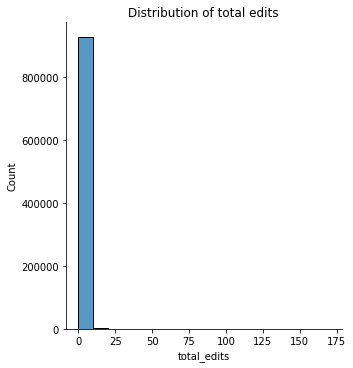

In [ ]:
hist_bins = list(range(data['total_edits'].min(), data['total_edits'].max()+10, 10))
sns.displot(data['total_edits'], bins=hist_bins)
plt.title("Distribution of total edits")
plt.show()

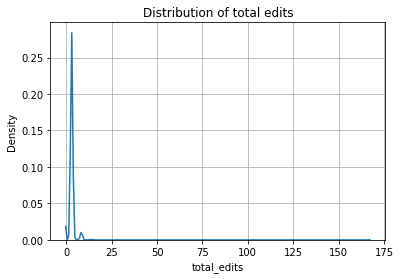

In [ ]:
sns.kdeplot(data['total_edits'])
plt.title("Distribution of total edits")
plt.grid()
plt.show()

Observation: <br>
1. Only few sentences has edits greater than 20

#####cumulative distribution

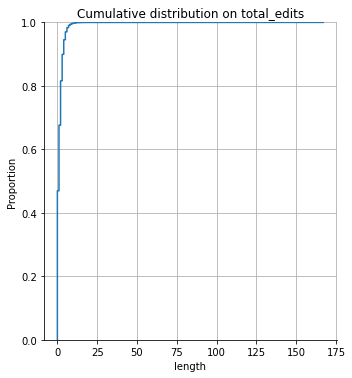

In [ ]:
sns.displot(data['total_edits'].values, kind='ecdf')
plt.xlabel("length")
plt.title("Cumulative distribution on total_edits")
plt.grid()
plt.show()

#####Statistics-Mean, Median, Mode

In [ ]:
print("Length statistics of correct sentences:")
print("="*100)

print("Minimum : ", data['total_edits'].min())
print("Maximum : ", data['total_edits'].max())
print("Mean : ", data['total_edits'].mean())
print("Median : ", data['total_edits'].median())
print("Mode : ", mode(data['total_edits'].values))

Length statistics of correct sentences:
Minimum :  0
Maximum :  167
Mean :  1.2664059852734735
Median :  1.0
Mode :  ModeResult(mode=array([0]), count=array([436385]))


**Observation:** <br>
1. min edits = 0 and max edits = 167
2. mean > median > mode. Hence data is right skewed
3. Maximum sentences has edits = 0

#####0-100 percentile in steps of 10

In [ ]:
p_value = list(range(0,101,10))

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["total_edits"].values,p))}')

0th percentile value is 0.0
10th percentile value is 0.0
20th percentile value is 0.0
30th percentile value is 0.0
40th percentile value is 0.0
50th percentile value is 1.0
60th percentile value is 1.0
70th percentile value is 2.0
80th percentile value is 2.0
90th percentile value is 4.0
100th percentile value is 167.0


**Observation:** <br>
1. 50% of data points has total_edits less than or equal to 1
2. 90% of data points has total_edits less tahn or equal to 3
3. We can see there is large variance between 90-100%

#####90-100 percentile in steps of 1

In [ ]:
p_value = list(range(90,101))

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["total_edits"].values,p))}')

90th percentile value is 4.0
91th percentile value is 4.0
92th percentile value is 4.0
93th percentile value is 4.0
94th percentile value is 4.0
95th percentile value is 5.0
96th percentile value is 5.0
97th percentile value is 5.0
98th percentile value is 6.0
99th percentile value is 7.0
100th percentile value is 167.0


**Observation:** <br>
1. 99% of data points has total edits 7
2. We can see there is large variance between 99-100

#####99.1-100 percentile in step of .1

In [ ]:
p_value = [99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]

for p in p_value:
  print(f'{p}th percentile value is {np.round(np.percentile(data["total_edits"].values,p))}')

99.1th percentile value is 8.0
99.2th percentile value is 8.0
99.3th percentile value is 8.0
99.4th percentile value is 8.0
99.5th percentile value is 9.0
99.6th percentile value is 9.0
99.7th percentile value is 10.0
99.8th percentile value is 11.0
99.9th percentile value is 12.0
100th percentile value is 167.0


**Observation:** <br>
1. 99.9% of data points has total edits less than or equal to 12.
2. Only .1% of datapoints has total edits greater than or equal to 12 

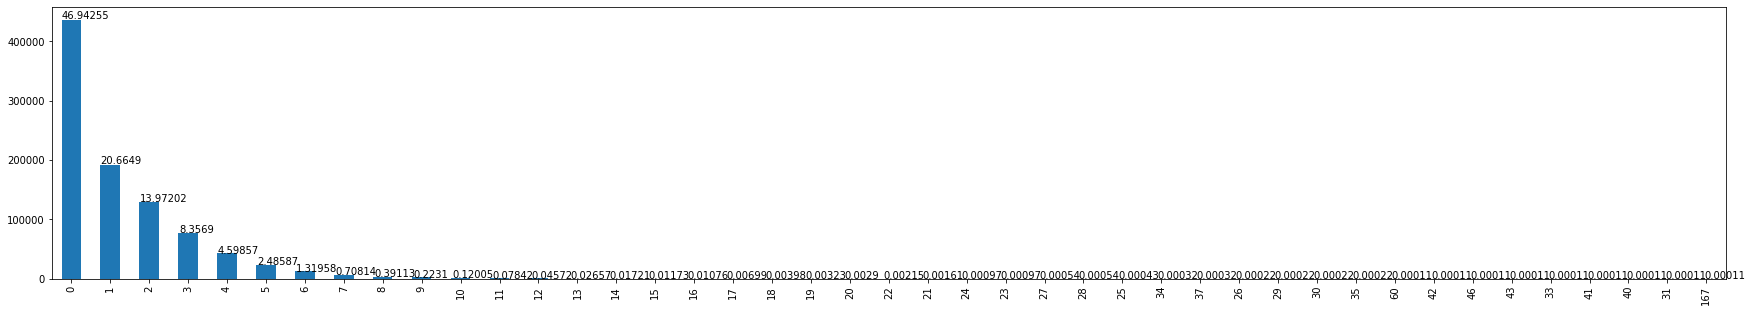

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))

data['total_edits'].value_counts(sort=True).plot(kind='bar',ax=ax)

for p in ax.patches:
  ax.annotate(str(np.round((p.get_height()/data.shape[0])*100, 5)), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

**Observation**: <br>
1. 47% (nearly 50) of data has 0 edits i.e, correct sentence == incorret sentences

##4.7.Bivariate Analysis

###4.7.1.How correct and incorrect sentens(word) length distributed

[]

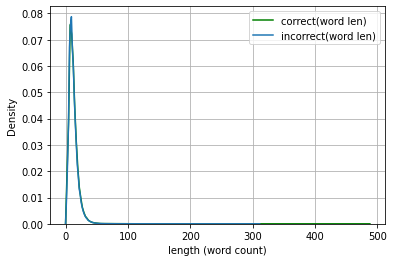

In [ ]:
sns.kdeplot(data['correct_word_len'], label='correct(word len)', color='green')
sns.kdeplot(data['incorrect_word_len'], label='incorrect(word len)')
plt.grid()
plt.legend()
plt.xlabel("length (word count)")
plt.plot()

**Observation:** <br>
1. We can see both distributions are overlapping on each other. 
2. Hence we can conclude incorrect_word_len and correct_word_len follows same distribution

[]

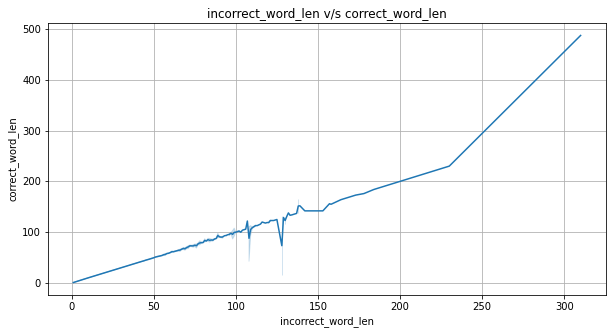

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x='incorrect_word_len', y='correct_word_len')
plt.grid()
plt.title("incorrect_word_len v/s correct_word_len")
plt.plot()

**Observation:** <br>
1. incorrect_word_len and correct_word_len are almost linearly corelated.
2. As incorrect sentence length increases, correct sentence length is also increasing

###4.7.2.Total edits v/s incorrect sent length

[]

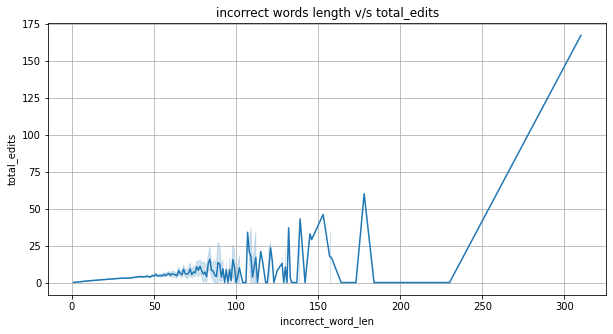

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x='incorrect_word_len', y='total_edits')
plt.grid()
plt.title("incorrect words length v/s total_edits")
plt.plot()

**Observation:** <br>
1. incorrect sent len and total_edits are not perfectly linearly corelated 
2. We can see when the sent len between 0-50, total_edits is linearly related 
3. when length between 250-310, total_edits is linearly related. 
4. Hence we can conclude as incorrect sentences length increases, total_edits and length has linear relationship

##4.8.Vocabulary

###4.8.1.Incorrect

In [ ]:
cv_incorrect = CountVectorizer()
cv_incorrect.fit(data['incorrect'].astype(str).tolist())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
print('Incorrect vocab size = ', len(cv_incorrect.get_feature_names()))

Incorrect vocab size =  105044


###4.8.2.Correct

In [ ]:
cv_correct = CountVectorizer()
cv_correct.fit(data['correct'].astype(str).tolist())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
print('Correct vocab size = ', len(cv_correct.get_feature_names()))

Correct vocab size =  89222


**Observation:** <br>
1. incorrect has vocabulary size of 105044
2. correct vocabulary has size of 89222
3. Incorrect vocabulary size is greater than correct vocabulary. 
4. This is because we incorrect contains miss spelled wods, incorrect words, words in different forms etc

In [ ]:
incorrect_vocab = set(cv_incorrect.get_feature_names())
correct_vocab = set(cv_correct.get_feature_names())

total_words_cnt = len(incorrect_vocab.union(correct_vocab))
total_incorrect_words_cnt = len(incorrect_vocab.difference(correct_vocab))
cnt_correct_words_from_both = len(incorrect_vocab.intersection(correct_vocab))
total_correct_words_cnt = len(correct_vocab.difference(incorrect_vocab)) + cnt_correct_words_from_both


In [ ]:
print("Count of words from incorrect sentences vocabulary: ", len(incorrect_vocab))
print("Count of words from correct sentences vocabulary: ", len(correct_vocab))
print("\n")
print("Total words: ", total_words_cnt)
print(f"Total incorrect words: {total_incorrect_words_cnt} percentage: {np.round((total_incorrect_words_cnt/total_words_cnt)*100, 4)}")
print(f"Total correct words: {total_correct_words_cnt} percentage: {np.round((total_correct_words_cnt/total_words_cnt)*100, 4)}")

Count of words from incorrect sentences vocabulary:  105044
Count of words from correct sentences vocabulary:  89222


Total words:  114188
Total incorrect words: 24966 percentage: 21.8639
Total correct words: 89222 percentage: 78.1361


**Observation:** <br>
1. There are 24975 words which are pesent only in incorrect vocabulary not in correct vocabulary. 
2. That means there are 24975 incorrect words. 


**Observation:** <br>
1. There are total of 114198 words. 
2. amoung which 21% of words are incorrect (21%)
3. And 89223 words are correct (78%)
4. Percentage of incorrect words are less than  correct words. 

##5.Final Summarization

**Observation:** <br>
1. We are working on lang8 dataset <br>
(source:: https://docs.google.com/forms/d/e/1FAIpQLSflRX3h5QYxegivjHN7SJ194OxZ4XN_7Rt0cNpR2YbmNV-7Ag/viewform)

Tomoya Mizumoto, Mamoru Komachi, Masaaki Nagata and Yuji Matsumoto.
Mining Revision Log of Language Learning SNS for Automated Japanese
Error Correction of Second Language Learners. In Proceedings of the
5th International Joint Conference on Natural Language Processing
(IJCNLP), pp.147-155. Chiang Mai, Thailand, November 2011.

Toshikazu Tajiri, Mamoru Komachi and Yuji Matsumoto. Tense and Aspect
Error Correction for ESL Learners Using Global Context. In Proceedings
of the 50th Annual Meeting of the Association for Computational
Linguistics: Short Papers (oral), pp.198-202. Jeju Island, Korea, July 2012.

2. Data is present in .m2 file "lang8.train.auto.bea19.m2"

3. In .m2 file line followed by S is original/incorrect sentence. (sentence which needs to be corrected), and sentence follwed by A is sentnce annotated by annotator(0,1,2,3,4). Annotated sentences are nothing but corrected sentences.

4. For our case study we are only taking sentences annotated by annotator 0. 

5. .m2 file has total of 1037562  sentences. 

6. Each datapoints/sentences are preprocessed (removal of special character)  

7. Incorrect Sentence Summary: 

  *   range: 1-310 (min-max)
  *   mean: 11
  *   90th percentile: 20 
  *   99th percentile: 36
  *   But sentences whose length is greater than 36 is not an outlier/random point. They are actual sentence. 

8. Correct Sentence Summary:

  *   range: 1-488 (min-max)
  *   mean: 11
  *   90th percentile: 21
  *   99th percentile: 36
  *    But sentences whose length is greater than 36 is not an outlier/random point. They are actual sentence.

9. Total edits

  *   range: 0-167
  *   mean: 1
  *   90th percentile: 3
  *   99th percentile: 7
  *   There are many sentences with edits = 0. That means those sentences are correct. We are not removing those sentences, because moel should know this is right sentence and it doen't require ant changes

10. As sentences length increase toatl edits has also increased. 

11. We have also observed as incorrect sentence length increases, correct sentence length also increases

11. incorrect vocab size > correct vocab size (incorrect cvocab contains miss spelled words)


























